In [1]:
#importing the Neccessary libraries
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
#Download yolov3 weights
#Download yolov3.cfg
#Download coco.names


#Loading the Pre-Trained Model
weights_path = "E:/yolo_files/yolov3.weights"
config_path = "E:/yolo_files/yolov3.cfg"

#Loading the yolo model
net = cv2.dnn.readNet(weights_path, config_path)
layer_names = net.getLayerNames()

# Fix: Convert numpy.int32 to int before accessing list elements
output_layers = [layer_names[int(i) - 1] for i in net.getUnconnectedOutLayers()]

print("Output Layers:", output_layers)

Output Layers: ['yolo_82', 'yolo_94', 'yolo_106']


In [3]:
#Load Video
video_path= "E:/dataset_video.mp4"
cap = cv2.VideoCapture(video_path)

In [4]:
def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

crowd_distance_threshold = 50
crowd_frame_threshold = 3
detected_crowds = []

frame_count = 0
crowd_tracker = {}

                      
                      
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    height, width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if class_id == 0 and confidence > 0.5: #class_id 0 indicates the person
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype('int')
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    persons = [boxes[i[0]] for i in indices]

    # Calculate person centers for crowd analysis
    person_centers = [(x + w // 2, y + h // 2) for x, y, w, h in persons]
    groups = []
    for i, pt1 in enumerate(person_centers):
        group = [pt1]
        for j, pt2 in enumerate(person_centers):
            if i != j and euclidean_distance(pt1, pt2) < crowd_distance_threshold:
                group.append(pt2)
        if len(group) >= 3:  # Group of 3 or more persons
            groups.append(group)

    # Track groups across frames
    for group in groups:
        key = tuple(sorted(group))
        if key in crowd_tracker:
            crowd_tracker[key] += 1
        else:
            crowd_tracker[key] = 1

    # Log detected crowds
    for key, count in list(crowd_tracker.items()):
        if count >= crowd_frame_threshold:
            detected_crowds.append((frame_count, len(key)))
            del crowd_tracker[key]

    # Visualize: Draw bounding boxes and display info
    for x, y, w, h in persons:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display person count
    cv2.putText(frame, f"People Count: {len(persons)}", (20, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display crowd info if any
    if detected_crowds:
        cv2.putText(frame, f"Crowd Detected!", (20, 100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

  
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

df = pd.DataFrame(detected_crowds, columns=["Frame Number", "Person Count in Crowd"])
df.to_csv("C:/Users/91956/IMAGE PROCESSING/crowd_detection_results.csv", index=False)


In [10]:
print(f"Tracking Group: {key}, Count: {crowd_tracker[key]}")



Tracking Group: ((362, 552), (409, 567), (457, 563)), Count: 1


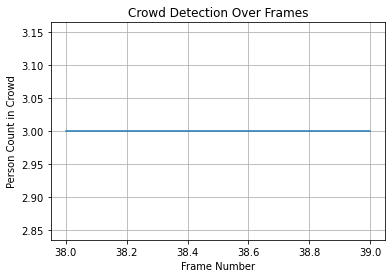

In [11]:



df.plot(x="Frame Number", y="Person Count in Crowd", kind="line", title="Crowd Detection Over Frames", legend=False)
plt.xlabel("Frame Number")
plt.ylabel("Person Count in Crowd")
plt.title("Crowd Detection Over Frames")
plt.grid(True)
plt.show()

